# Analyse the classifier of PyFeat

In [18]:
from feat import Detector # type: ignore
import cv2 # type: ignore
import os
import torch
import numpy as np
from feat.utils import FEAT_EMOTION_COLUMNS # type: ignore
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Read the images & predict the emotions

In [19]:
if torch.backends.cudnn.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
    device=device,
)

The images must be in the folder `./data/{emotion}` where `emotion` is the emotion of the images. The available emotions are `angry`, `happy`, `sad` and `neutral`.

In [29]:
emotions = ["angry", "happy", "sad", "neutral"]
pyfeat_emotions = ["anger", "happiness", "sadness", "neutral"]

true_labels = []
predicted_labels = []

def handle_file(file):
    frame = cv2.imread(f"data/{emotion}/{file}")

    detected_faces = detector.detect_faces(frame)
    detected_landmarks = detector.detect_landmarks(frame, detected_faces)
    detected_emotions = detector.detect_emotions(frame, detected_faces, detected_landmarks)[0]
    if len(detected_emotions) > 0:
        detected_emotion = FEAT_EMOTION_COLUMNS[np.argmax(detected_emotions[0])]
        if detected_emotion not in pyfeat_emotions:
            detected_emotion = "neutral"
        predicted_labels.append(detected_emotion)
        true_labels.append(pyfeat_emotion)

for i in range(len(emotions)):
    emotion = emotions[i]
    pyfeat_emotion = pyfeat_emotions[i]
    for file in os.listdir(f"data/{emotion}"):
        handle_file(file)
    for file in os.listdir(f"data/kaggle/{emotion}"):
        handle_file(file)

c:\Users\Jurek\Anaconda3\envs\iis_project_test_env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Evaluate the performance

Accuracy: 0.6666666666666666


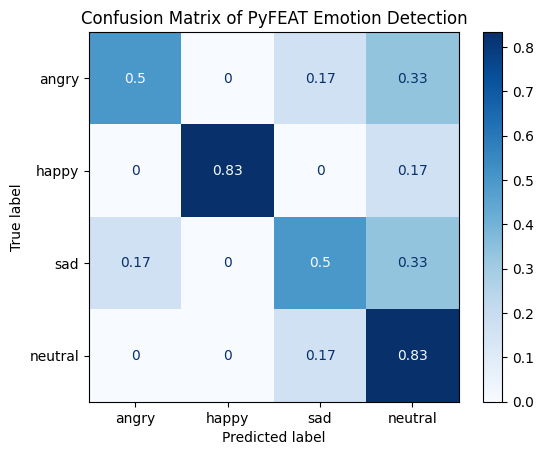

In [31]:
accuracy = np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(np.array(true_labels), np.array(predicted_labels), normalize='true', labels=pyfeat_emotions)
dsp = ConfusionMatrixDisplay(cm, display_labels=emotions)
dsp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of PyFEAT Emotion Detection")
plt.show()